# Introduction

This notebook serves as a tutorial for using the DESeq2 package. Please be sure to consult the excellent vignette provided by the DESeq2 package. Hopefully, we will also get a chance to review the edgeR package (which also has a very nice vignette which I suggest that you review)

# Load packages

Load requisite R packages

In [1]:
sessionInfo()
library()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

loaded via a namespace (and not attached):
 [1] R6_2.1.2        magrittr_1.5    IRdisplay_0.3   pbdZMQ_0.2-3   
 [5] tools_3.3.1     base64enc_0.1-3 uuid_0.1-2      stringi_1.1.1  
 [9] IRkernel_0.6    jsonlite_0.9.22 stringr_1.0.0   digest_0.6.9   
[13] repr_0.7        evaluate_0.9   

In [2]:
library(DESeq2)
library(dplyr)
library(qvalue)
options(width=100)


Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit


Attaching package: ‘S4Vectors’

The following objects are masked from ‘package:base’:

    c

# Import Data

Let's set the file name containing the phenotype data and the directory storing the count files from the htseq-count step. You will have to adjust these strings. Note that it is assumed that all count files are stored under a single directory.

In [3]:
datadir<-"/home/jovyan/work/share/2016/DESeqTutorial/Prelim"
list.files(datadir)
#setwd(datadir)

[1] "7A_E.csv"             "7A_G.csv"             "7A_K.csv"             "7A_N.csv"            
 [5] "7A_P.csv"             "7B_E.csv"             "7B_G.csv"             "7B_K.csv"            
 [9] "7B_N.csv"             "7B_P.csv"             "7C_E.csv"             "7C_G.csv"            
[13] "7C_K.csv"             "7C_N.csv"             "7C_P.csv"             "8A_E.csv"            
[17] "8A_G.csv"             "8A_K.csv"             "8A_N.csv"             "8A_P.csv"            
[21] "8B_E.csv"             "8B_G.csv"             "8B_K.csv"             "8B_N.csv"            
[25] "8B_P.csv"             "8C_E.csv"             "8C_G.csv"             "8C_K.csv"            
[29] "8C_N.csv"             "8C_P.csv"             "deseq.R"              "deseq.Rout"          
[33] "NGS-Summer2015.RData"

Next, put the filenames into a data frame

In [4]:
phdata<-data.frame(fname=list.files(patter="*.csv",path=datadir),stringsAsFactors=FALSE)
head(phdata)

fname
1 7A_E.csv
2 7A_G.csv
3 7A_K.csv
4 7A_N.csv
5 7A_P.csv
6 7B_E.csv

It is always a good idea to check the dimension of the file you have read in

In [5]:
dim(phdata)

[1] 30  1

Extract the label from the filename. Why should one reorder columns? See DESeq2 help file

In [6]:
phdata<-transmute(phdata,sample=substr(fname,1,4),fname)
head(phdata)

sample    fname
1   7A_E 7A_E.csv
2   7A_G 7A_G.csv
3   7A_K 7A_K.csv
4   7A_N 7A_N.csv
5   7A_P 7A_P.csv
6   7B_E 7B_E.csv

Add some design info to the data frame

In [73]:
phdata<-mutate(phdata,
               trt=as.factor(substr(sample,1,1)),
               repl=substr(sample,2,2),
               team=as.factor(substr(sample,4,4)),
               md5=tools::md5sum(file.path(datadir,fname)))
head(phdata)

sample    fname trt repl team                              md5
1   7A_E 7A_E.csv   7    A    E 263e8cd3d8bbb72fac8600de41b12e73
2   7A_G 7A_G.csv   7    A    G 8e3447446c11b3cf33496de751a0e7b0
3   7B_E 7B_E.csv   7    B    E 51d8902b1dee08f1af3affe6510a87a5
4   7B_G 7B_G.csv   7    B    G 915c69bb86b160a03c432220692fa4de
5   7C_E 7C_E.csv   7    C    E 49a549a26e58dd5c13bd931a794c0ec3
6   7C_G 7C_G.csv   7    C    G 0c34bdd506a5b208f75996c5247e81cf

 For this analysis, we pick the data from team E or G

In [74]:
phdata<-filter(phdata,team%in%c("E","G"))
phdata

sample    fname trt repl team                              md5
1    7A_E 7A_E.csv   7    A    E 263e8cd3d8bbb72fac8600de41b12e73
2    7A_G 7A_G.csv   7    A    G 8e3447446c11b3cf33496de751a0e7b0
3    7B_E 7B_E.csv   7    B    E 51d8902b1dee08f1af3affe6510a87a5
4    7B_G 7B_G.csv   7    B    G 915c69bb86b160a03c432220692fa4de
5    7C_E 7C_E.csv   7    C    E 49a549a26e58dd5c13bd931a794c0ec3
6    7C_G 7C_G.csv   7    C    G 0c34bdd506a5b208f75996c5247e81cf
7    8A_E 8A_E.csv   8    A    E edaaefaf7ddeb1119f29cf3d5682d4ed
8    8A_G 8A_G.csv   8    A    G a07dc7cfdef1a7a903b2836ca7cd64aa
9    8B_E 8B_E.csv   8    B    E f7d52ce9ffc0e61d7e371d072ebc0a43
10   8B_G 8B_G.csv   8    B    G 0a037d9ec47232d333c7d0b2d7eaf76b
11   8C_E 8C_E.csv   8    C    E 1e668998cb9947b80f3e813a7428bfb5
12   8C_G 8C_G.csv   8    C    G d9d4574f07eb3b4c7d81cc18228bd829

Now, we import the counts. Note that the first argument is the sample table while the second is the directory storing the count files. The last argument specifies the design. More on this later.

In [75]:
dds<-DESeqDataSetFromHTSeqCount(sampleTable=phdata,design=~ trt,directory = datadir)

# Inspect object

Let's has a look at the object we have created.

In [10]:
dds

class: DESeqDataSet 
dim: 4444 12 
metadata(1): version
assays(1): counts
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(0):
colnames(12): 7A_E 7A_G ... 8C_E 8C_G
colData names(4): trt repl team md5

Note that this object is of class DESeqDataSet. 

In [11]:
class(dds)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

The object dds has the following slots.

In [13]:
slotNames(dds)

[1] "design"             "dispersionFunction" "rowRanges"          "colData"           
[5] "assays"             "NAMES"              "elementMetadata"    "metadata"

To get a slot use @

In [14]:
dds@colData

DataFrame with 12 rows and 4 columns
          trt        repl        team                              md5
     <factor> <character> <character>                      <character>
7A_E        7           A           E 263e8cd3d8bbb72fac8600de41b12e73
7A_G        7           A           G 8e3447446c11b3cf33496de751a0e7b0
7B_E        7           B           E 51d8902b1dee08f1af3affe6510a87a5
7B_G        7           B           G 915c69bb86b160a03c432220692fa4de
7C_E        7           C           E 49a549a26e58dd5c13bd931a794c0ec3
...       ...         ...         ...                              ...
8A_G        8           A           G a07dc7cfdef1a7a903b2836ca7cd64aa
8B_E        8           B           E f7d52ce9ffc0e61d7e371d072ebc0a43
8B_G        8           B           G 0a037d9ec47232d333c7d0b2d7eaf76b
8C_E        8           C           E 1e668998cb9947b80f3e813a7428bfb5
8C_G        8           C           G d9d4574f07eb3b4c7d81cc18228bd829

Let's look at the design

In [15]:
dds@design

~trt

The first thing you may want to do is to have a look at the raw counts you have imported. You can use the counts(). Let's looks the first three genes (use the head() function to avoid printing out all genes). Before that notw the dimension of the count matrix (does it look correct?)

In [16]:
dim(counts(dds))

[1] 4444   12

Now print the raw counts for the first three genes (how can you verify this looking at the files from htseq-count)

In [17]:
head(counts(dds),3)

7A_E 7A_G 7B_E 7B_G 7C_E 7C_G 8A_E 8A_G 8B_E 8B_G 8C_E 8C_G
gene0     9   17   12   22   19   20   21   23    8   29   10   22
gene1   108  170  119  241  155  149  193  224  164  215  196   98
gene10    3    0    2    1    2    2    6    1    3    0    7    3

## Slots of an S4 class

This gives the design of the study

In [18]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0x70d01a8>

This slots return gene specific information (it will be populated later)

# Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$. Here $s_j$ is the sample $j$ specific size factor.

## Size Factors

We begin by estimating the size factors $s_1,\ldots,s_n$:

In [19]:
dds <- estimateSizeFactors(dds)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [20]:
dds

class: DESeqDataSet 
dim: 4444 12 
metadata(1): version
assays(1): counts
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(0):
colnames(12): 7A_E 7A_G ... 8C_E 8C_G
colData names(5): trt repl team md5 sizeFactor

Note that there is a sizeFactor added to colData. Let's look at it more carefully

You can also get the size factors directly (why are there six size factors?)

In [21]:
sizeFactors(dds)

7A_E      7A_G      7B_E      7B_G      7C_E      7C_G      8A_E      8A_G      8B_E      8B_G 
0.8313968 0.9449002 0.8758095 1.1526785 0.9981213 1.0194363 1.1044135 1.0158512 1.1677638 0.9362123 
     8C_E      8C_G 
1.2777049 0.9422983

It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [22]:
round(sizeFactors(dds),3)

7A_E  7A_G  7B_E  7B_G  7C_E  7C_G  8A_E  8A_G  8B_E  8B_G  8C_E  8C_G 
0.831 0.945 0.876 1.153 0.998 1.019 1.104 1.016 1.168 0.936 1.278 0.942

Now that the size factors have been estimated, we can get "normalized" counts

In [23]:
head(counts(dds),3)
head(counts(dds,normalize=TRUE),3)

7A_E 7A_G 7B_E 7B_G 7C_E 7C_G 8A_E 8A_G 8B_E 8B_G 8C_E 8C_G
gene0     9   17   12   22   19   20   21   23    8   29   10   22
gene1   108  170  119  241  155  149  193  224  164  215  196   98
gene10    3    0    2    1    2    2    6    1    3    0    7    3

7A_E      7A_G       7B_E        7B_G       7C_E       7C_G       8A_E        8A_G
gene0   10.825156  17.99132  13.701609  19.0859805  19.035762  19.618685  19.014618  22.6411112
gene1  129.901878 179.91319 135.874292 209.0782412 155.291739 146.159203 174.753391 220.5047356
gene10   3.608385   0.00000   2.283602   0.8675446   2.003764   1.961869   5.432748   0.9843961
             8B_E      8B_G       8C_E       8C_G
gene0    6.850701  30.97588   7.826533  23.347170
gene1  140.439361 229.64877 153.400056 104.001032
gene10   2.569013   0.00000   5.478573   3.183705

Note that these are the counts divided by the size factors. Compare the first row of the last table ("normalized" counts for gene 1) to the hand calculation below.

In [24]:
counts(dds)[1,]/sizeFactors(dds)

7A_E      7A_G      7B_E      7B_G      7C_E      7C_G      8A_E      8A_G      8B_E      8B_G 
10.825156 17.991319 13.701609 19.085981 19.035762 19.618685 19.014618 22.641111  6.850701 30.975880 
     8C_E      8C_G 
 7.826533 23.347170

Exercise: How do you get the raw counts for gene  "GeneID:12930116"?

In [25]:
counts(dds)["gene0",]

7A_E 7A_G 7B_E 7B_G 7C_E 7C_G 8A_E 8A_G 8B_E 8B_G 8C_E 8C_G 
   9   17   12   22   19   20   21   23    8   29   10   22

Exercise: How do you get the normalized counts for gene gene10 for the first 3 sample?

In [26]:
counts(dds,normalize=TRUE)["gene10",1:3]

7A_E     7A_G     7B_E 
3.608385 0.000000 2.283602

Exercise: Get a summary (mean, median, quantiles etc ) of the size factors

In [27]:
summary(sizeFactors(dds))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.8314  0.9408  1.0070  1.0220  1.1160  1.2780 

Before going to the next step, let's look at the dispersionFunction slot

In [28]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0x70d01a8>

## Dispersion Parameters

Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{m}$

In [29]:
dds<-estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Now inspect the dds object again and note that the rowRanges slot has extra information ("metadata column names(0):" before versus "column names(9): baseMean baseVar ... dispOutlier dispMAP")

In [30]:
dds

class: DESeqDataSet 
dim: 4444 12 
metadata(1): version
assays(2): counts mu
rownames(4444): gene0 gene1 ... gene998 gene999
rowData names(9): baseMean baseVar ... dispOutlier dispMAP
colnames(12): 7A_E 7A_G ... 8C_E 8C_G
colData names(5): trt repl team md5 sizeFactor

Note that the dispersionfunction slot is now populated

In [32]:
dds@dispersionFunction

function (q) 
coefs[1] + coefs[2]/q
<environment: 0xed3bde0>
attr(,"coefficients")
asymptDisp  extraPois 
 0.1483272  0.7045166 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 1.223137
attr(,"dispPriorVar")
[1] 1.001814

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [33]:
alphas<-dispersions(dds)

Verify that the number of dispersion factors equals the number of genes

In [34]:
length(alphas)

[1] 4444

Print the dispersion factors for the first 5 genes rounded to four decimal points

In [35]:
round(alphas[1:5],4)

[1] 0.1471 0.0653 0.3295 0.0463 0.1798

Extract the metadata using mcols() for the first four genes (recall that it was previously 

In [36]:
mcols(dds)[1:4,]

DataFrame with 4 rows and 9 columns
    baseMean    baseVar   allZero dispGeneEst   dispFit dispersion  dispIter dispOutlier    dispMAP
   <numeric>  <numeric> <logical>   <numeric> <numeric>  <numeric> <numeric>   <logical>  <numeric>
1  17.576210   47.27392     FALSE  0.13360718 0.1884107 0.14714648         8       FALSE 0.14714648
2 164.913823 1500.78558     FALSE  0.05230130 0.1525992 0.06528558         9       FALSE 0.06528558
3   2.364467    3.36344     FALSE  0.00000001 0.4462872 0.32947892         8       FALSE 0.32947892
4  23.215440   22.21959     FALSE  0.00000001 0.1786741 0.04628790         8       FALSE 0.04628790

Exercise: Provide statistical summaries of the dispersion factors

In [37]:
summary(dispersions(dds))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
 0.00721  0.06474  0.12740  0.44760  0.27100 12.00000       86 

Exercise: Summarize the dispersion factors using a box plot (may want to log transform)

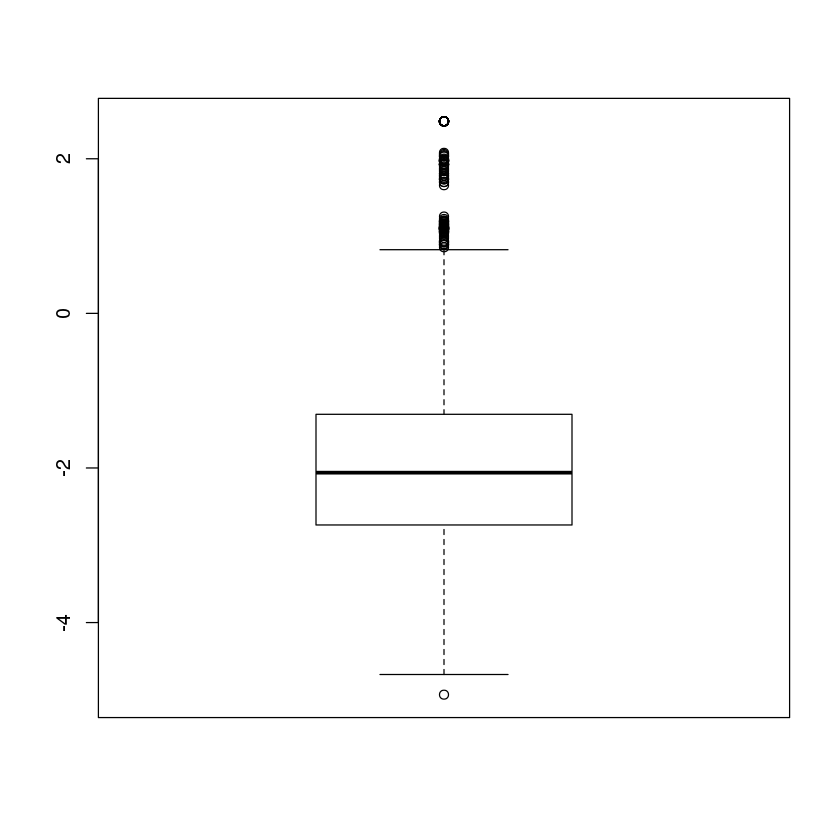

In [38]:
boxplot(log(dispersions(dds)))

# Differential Expression Analysis

We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [39]:
ddsDE<-DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


We can get the results for the differential expression analysis using results()

In [40]:
myres<-results(ddsDE)

Let's look at the results for the first four genes

In [41]:
myres[1:4,]

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat    pvalue      padj
         <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric>
gene0    17.576210      0.1014338 0.3277597 0.3094761 0.7569594 0.9017982
gene1   164.913823      0.0897070 0.2115254 0.4240957 0.6714960 0.8554958
gene10    2.364467      0.5086794 0.4688188 1.0850236 0.2779112        NA
gene100  23.215440      0.1008462 0.2333443 0.4321775 0.6656124 0.8539160

Calculate BH adjusted P-values by "hand" using the p.adjust() function

In [42]:
BH=p.adjust(myres$pvalue,"BH")
BH[1:4]

[1] 0.9273554 0.8940033 0.6347948 0.8926170

You can get the descriptions for the columns from the DE analysis

In [43]:
data.frame(desc=mcols(myres)$description)

desc
1 mean of normalized counts for all samples
2        log2 fold change (MAP): trt 8 vs 7
3                standard error: trt 8 vs 7
4                Wald statistic: trt 8 vs 7
5             Wald test p-value: trt 8 vs 7
6                      BH adjusted p-values

We can get summaries of the results:

In [44]:
summary(myres,0.05)


out of 4358 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)     : 59, 1.4% 
LFC < 0 (down)   : 85, 2% 
outliers [1]     : 15, 0.34% 
low counts [2]   : 676, 16% 
(mean count < 3)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



You can sort the results by say the unadjusted P-values

In [45]:
myres[order(myres[["pvalue"]])[1:4],]


log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4 rows and 6 columns
          baseMean log2FoldChange     lfcSE      stat       pvalue         padj
         <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
gene2775 229.90491       2.407678 0.4847718  4.966622 6.812925e-07 0.0008350875
gene1952 148.21389      -1.467640 0.3007992 -4.879136 1.065517e-06 0.0008350875
gene2904 266.41432      -2.008647 0.4116939 -4.878981 1.066355e-06 0.0008350875
gene1514  11.84518      -1.657296 0.3399473 -4.875157 1.087219e-06 0.0008350875

To get the list of genes with unadjusted P-values < 0.00001 and absolute log2 FC of more than 4

In [46]:
subset(myres,pvalue<0.00001&abs(log2FoldChange)>4)

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 0 rows and 6 columns

To get the list of genes with unadjusted P-values < 0.00001 and upregulated genes with log2 FC of more than 4

In [47]:
subset(myres,pvalue<0.00001&log2FoldChange>4)

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 0 rows and 6 columns

The P-values for the four top genes are beyond machine precision. You can use the format.pval() function to properly format the P-values. PLEASE promote ending the practice of publishing P-values below machine precision.  (that would be akin to stating the weight of an object that weighs less than one pound with scale that whose minimum weight spec is 1lbs).

In [48]:
myres$pval=format.pval(myres$pvalue)
myres[order(myres[["pvalue"]])[1:4],]

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4 rows and 7 columns
          baseMean log2FoldChange     lfcSE      stat       pvalue         padj        pval
         <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric> <character>
gene2775 229.90491       2.407678 0.4847718  4.966622 6.812925e-07 0.0008350875  6.8129e-07
gene1952 148.21389      -1.467640 0.3007992 -4.879136 1.065517e-06 0.0008350875  1.0655e-06
gene2904 266.41432      -2.008647 0.4116939 -4.878981 1.066355e-06 0.0008350875  1.0664e-06
gene1514  11.84518      -1.657296 0.3399473 -4.875157 1.087219e-06 0.0008350875  1.0872e-06

Let's look at a volcano plot

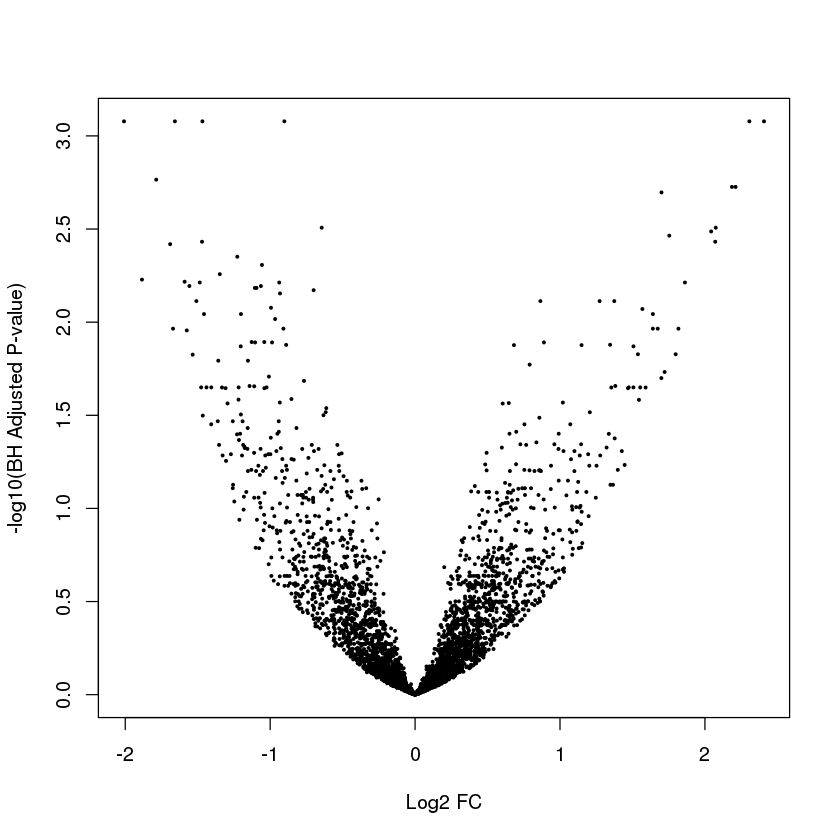

In [49]:
plot(myres$log2FoldChange,-log10(myres$padj),pch=19,cex=0.3,xlab="Log2 FC",ylab="-log10(BH Adjusted P-value)")

Extract results for genes gene11 and gene101

In [66]:
myres[c("gene11","gene101"),]

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 2 rows and 7 columns
          baseMean log2FoldChange     lfcSE      stat    pvalue      padj        pval
         <numeric>      <numeric> <numeric> <numeric> <numeric> <numeric> <character>
gene11   0.4926702     0.25894554 0.4642589 0.5577611 0.5770075        NA  0.57700753
gene101 53.7428338     0.06687321 0.2221519 0.3010247 0.7633956 0.9049117  0.76339565

Exercise: Annotate the hits with adjusted P-values < 0.05 and absolute log2 FC greater than 2 in red

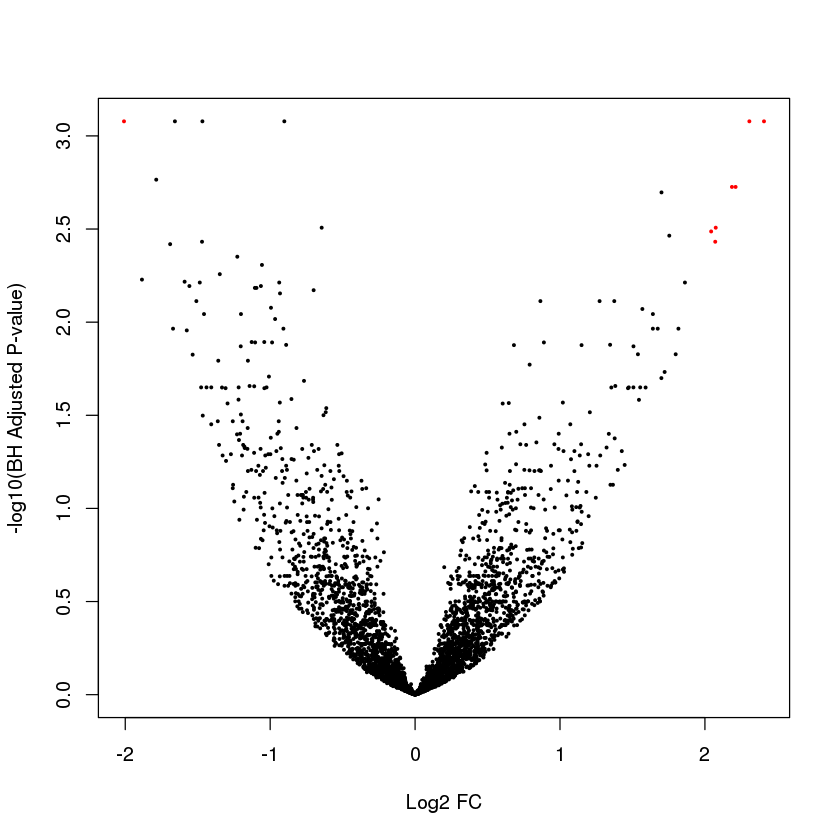

In [51]:
plot(myres$log2FoldChange,-log10(myres$padj),pch=19,cex=0.3,xlab="Log2 FC",ylab="-log10(BH Adjusted P-value)",col=ifelse(myres$padj<0.05&abs(myres$log2FoldChange)>2,"red","black"))

# Converting/Normalizing Counts to "Expressions" 

## Normalized Counts

We have already shown how to "normalize" the counts using the estimated size factors

In [52]:
head(counts(dds,normalize=TRUE),3)

7A_E      7A_G       7B_E        7B_G       7C_E       7C_G       8A_E        8A_G
gene0   10.825156  17.99132  13.701609  19.0859805  19.035762  19.618685  19.014618  22.6411112
gene1  129.901878 179.91319 135.874292 209.0782412 155.291739 146.159203 174.753391 220.5047356
gene10   3.608385   0.00000   2.283602   0.8675446   2.003764   1.961869   5.432748   0.9843961
             8B_E      8B_G       8C_E       8C_G
gene0    6.850701  30.97588   7.826533  23.347170
gene1  140.439361 229.64877 153.400056 104.001032
gene10   2.569013   0.00000   5.478573   3.183705

Plot the counts stratified by treatment for the 2nd gene

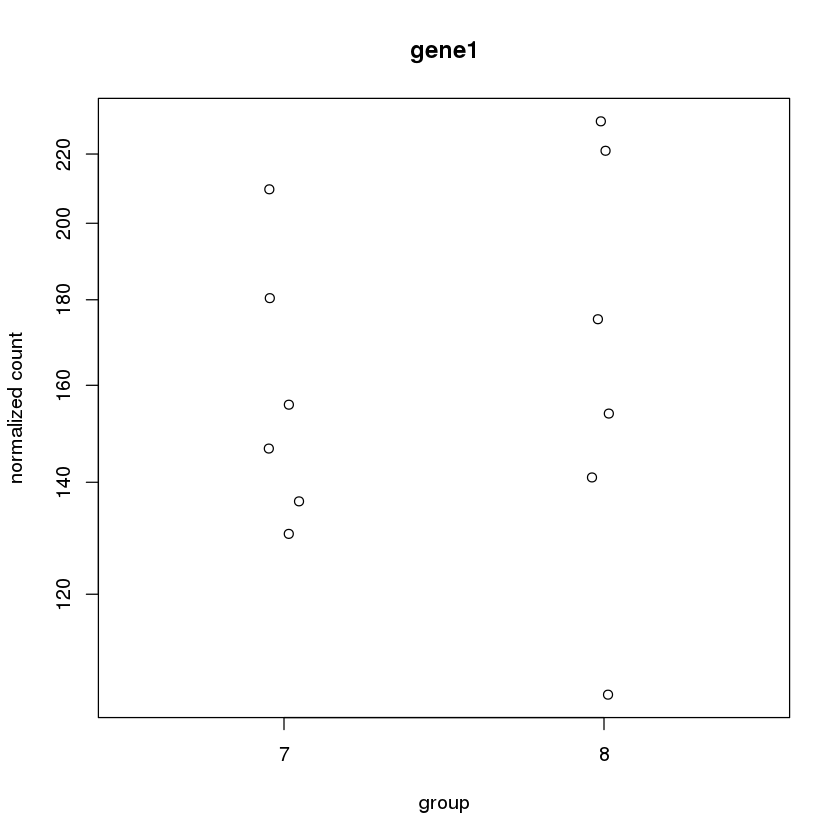

In [53]:
 plotCounts(dds, 2,intgroup="trt")

Or alternatively (better)

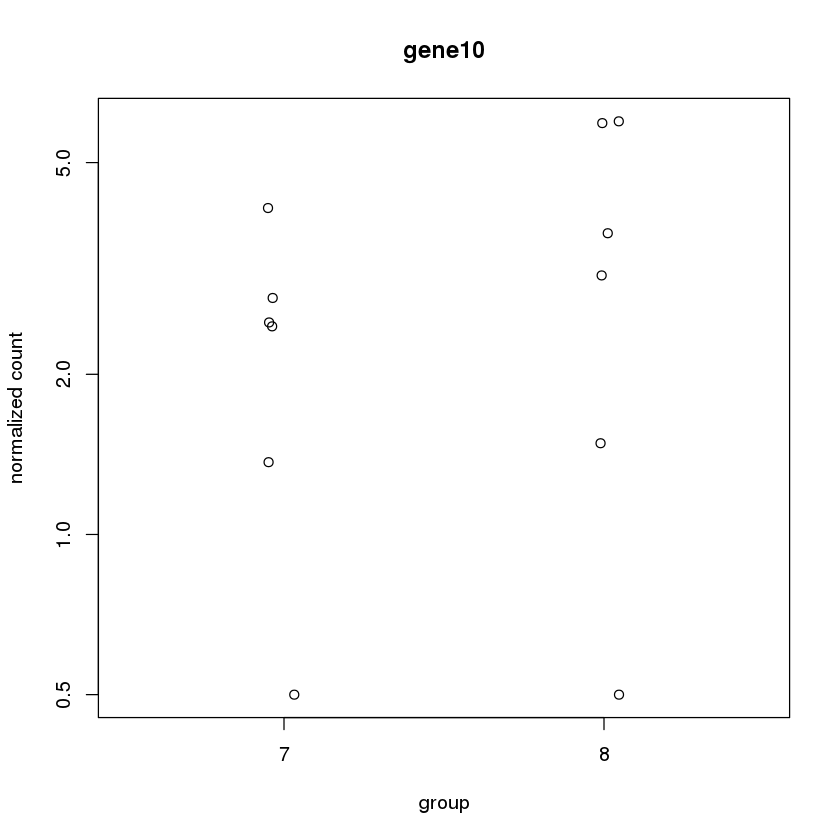

In [54]:
 plotCounts(dds, "gene10",intgroup="trt")

Now get this plot for the top hit

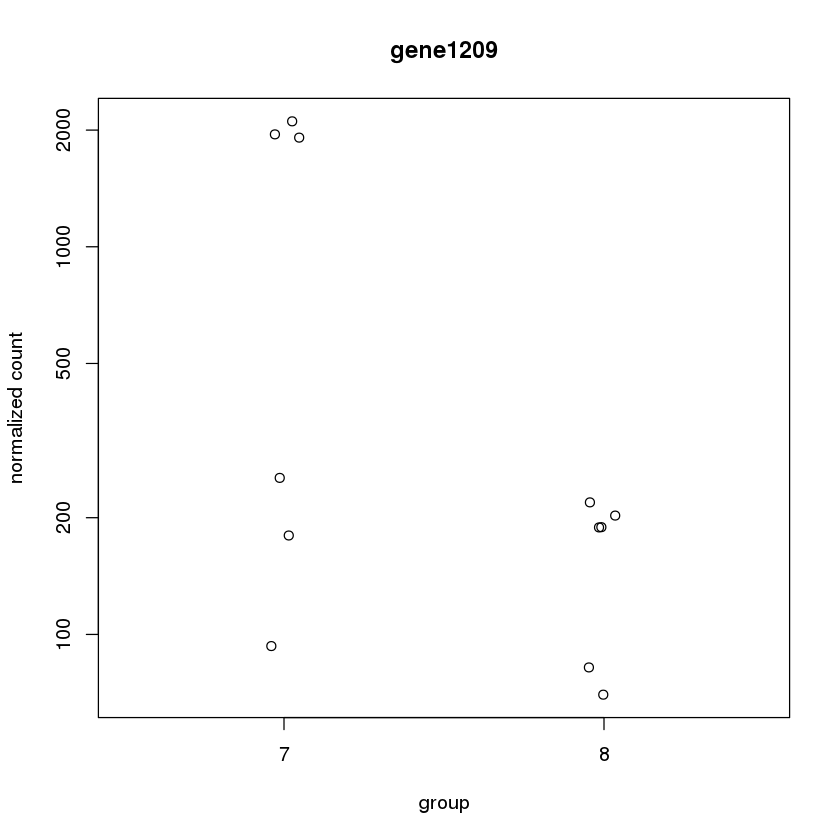

In [55]:
plotCounts(dds, "gene1209",intgroup="trt")

## FPM

Another approach is to FPM: fragments per million mapped fragments

In [56]:
head(fpm(dds),3)

7A_E      7A_G       7B_E        7B_G       7C_E       7C_G       8A_E        8A_G
gene0   8.137473  13.52441  10.299757  14.3472901  14.309540  14.747734  14.293645  17.0197486
gene1  97.649681 135.24412 102.139258 157.1680412 116.735717 109.870619 131.365407 165.7575516
gene10  2.712491   0.00000   1.716626   0.6521495   1.506267   1.474773   4.083899   0.7399891
             8B_E      8B_G       8C_E      8C_G
gene0    5.149800  23.28515   5.883352 17.550507
gene1  105.570905 172.63129 115.313704 78.179529
gene10   1.931175   0.00000   4.118347  2.393251

Let's calculate the FPM manually. For gene $i$ sample $j$, the FPM is defined as $\frac{K_{ij}}{D_j}\times 10^{6}$ where $D_j=\sum_{i=1} K_{ij}$ is the read depth for sample $j$. First get the read depth for each sample

In [57]:
D=colSums(counts(dds))
D

7A_E    7A_G    7B_E    7B_G    7C_E    7C_G    8A_E    8A_G    8B_E    8B_G    8C_E    8C_G 
1224153 1165807 1294576 1376841 1493765 1259416 1492923 1324560 1581586 1064510 1736478 1110169

By default, the fpm() function uses a robust approach. We will disable this right now as to replicate the standard FPM. Let's look at gene 1

In [58]:
fpm1<-fpm(dds,robust=FALSE)[1,]
fpm1

7A_E      7A_G      7B_E      7B_G      7C_E      7C_G      8A_E      8A_G      8B_E      8B_G 
 7.352022 14.582174  9.269444 15.978606 12.719538 15.880376 14.066365 17.364257  5.058214 27.242581 
     8C_E      8C_G 
 5.758783 19.816803

Now get the raw counts for gene 1

In [59]:
cnt1<-counts(dds)[1,]
cnt1

7A_E 7A_G 7B_E 7B_G 7C_E 7C_G 8A_E 8A_G 8B_E 8B_G 8C_E 8C_G 
   9   17   12   22   19   20   21   23    8   29   10   22

Now calculate the FPM for gene 1

In [60]:
myfpm1<-cnt1/D*1e6
myfpm1

7A_E      7A_G      7B_E      7B_G      7C_E      7C_G      8A_E      8A_G      8B_E      8B_G 
 7.352022 14.582174  9.269444 15.978606 12.719538 15.880376 14.066365 17.364257  5.058214 27.242581 
     8C_E      8C_G 
 5.758783 19.816803

This is how you check if two numeric columns are "equal"

In [61]:
min(abs(fpm1-myfpm1))

[1] 0

## FPKM

To calculate the FPKM (fragments per kilobase per million mapped fragments) we need to add annotation to assign the feature lengths. More specifically, for gene $i$ sample $j$, the FPKM is defined as $\frac{K_{ij}}{\ell_i D_j}\times 10^3 \times 10^{6}$ where $\ell_i$ is the "length" of gene $i$ (fragments for each $10^3$ bases in the gene for every  $\frac{D_j}{10^6}$ fragments. More on this later.

## Regularized log transformation

The regularized log transform can be obtained using the rlog() function. Note that an important argument for this function is blind (TRUE by default). The default "blinds" the normalization to the design. This is very important so as to not bias the analyses (e.g. class discovery 

In [62]:
rld<-rlog(dds,blind=TRUE)

Hierarchical clustering using rlog transformation

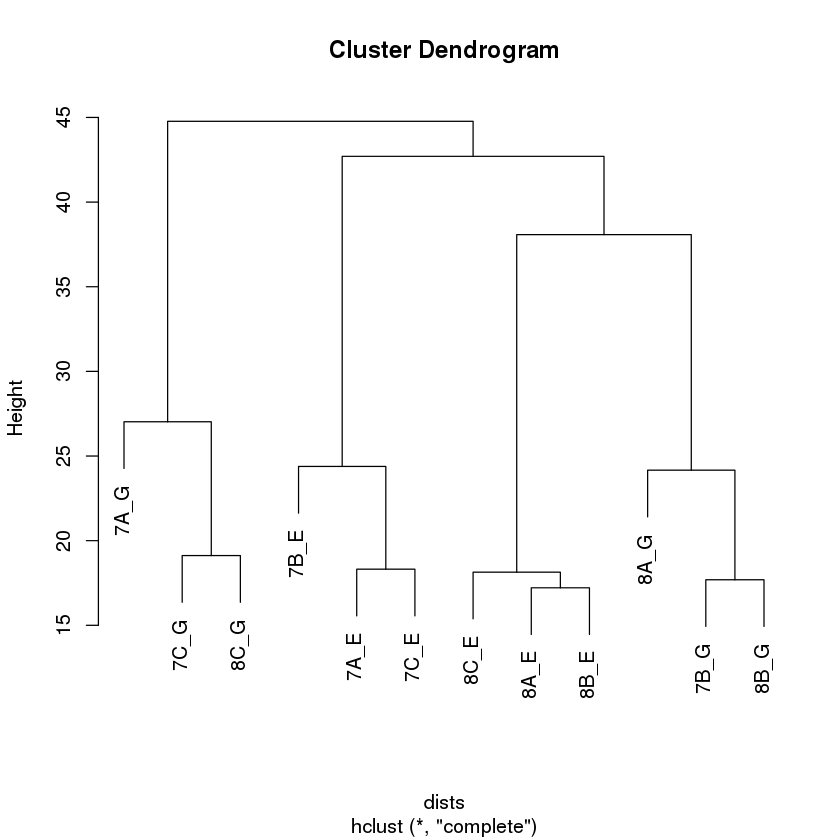

In [63]:
dists<-dist(t(assay(rld)))
plot(hclust(dists))


PC Analysis using the rlog transformation

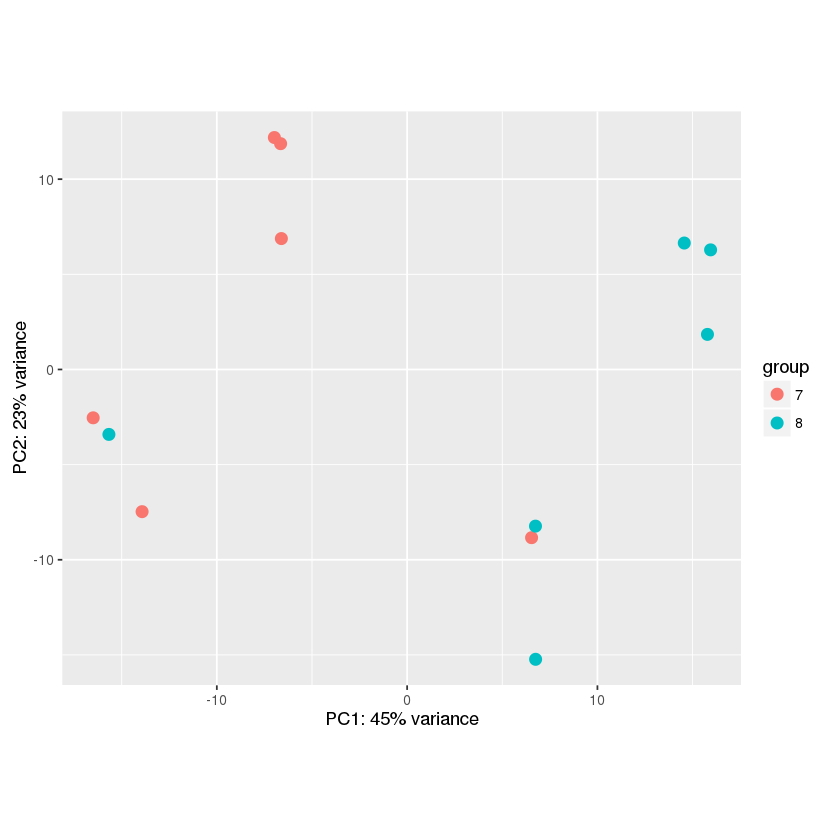

In [64]:
 plotPCA(rld,intgroup="trt")

## Change the design

### The current design is

In [76]:
design(dds)

~trt

### One can update the model to include other covariates. Suppose that we want to consider an additive model adjusting for the team effect. While this is a a good exercise, this is not a good model. Why?

In [77]:
design(dds)<- ~team+trt

### Now look at new design

In [83]:
design(dds)

ERROR: Error in (function (classes, fdef, mtable) : unable to find an inherited method for function ‘design’ for signature ‘"factor"’


### Now conduct analysis. Be sure to be the covariate of interest as last term when you update design

In [79]:
ddsDE1<-DESeq(dds)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


### Look at the results

In [80]:
results(ddsDE1)

log2 fold change (MAP): trt 8 vs 7 
Wald test p-value: trt 8 vs 7 
DataFrame with 4444 rows and 6 columns
           baseMean log2FoldChange     lfcSE       stat    pvalue      padj
          <numeric>      <numeric> <numeric>  <numeric> <numeric> <numeric>
gene0     17.576210     0.06091862 0.2779241  0.2191916 0.8265008 0.9162404
gene1    164.913823     0.09592256 0.1926099  0.4980147 0.6184737 0.7965539
gene10     2.364467     0.46309801 0.4368631  1.0600528 0.2891206 0.5330617
gene100   23.215440     0.09577773 0.2248745  0.4259163 0.6701688 0.8291296
gene1000   6.518029    -0.41888971 0.3770512 -1.1109623 0.2665846 0.5080035
...             ...            ...       ...        ...       ...       ...
gene995   1.6402253      0.6640623 0.4501005  1.4753643 0.1401146        NA
gene996  12.0752744     -0.2266075 0.2827058 -0.8015667 0.4228037 0.6595752
gene997   8.2583387     -0.2809066 0.3499425 -0.8027222 0.4221353 0.6595752
gene998  28.2195485     -0.1059640 0.2120636 -0.4996803 0.

In [65]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8       
 [4] LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] qvalue_2.4.2               dplyr_0.4.3                DESeq2_1.12.3             
 [4] SummarizedExperiment_1.2.3 Biobase_2.32.0             GenomicRanges_1.24.2      
 [7] GenomeInfoDb_1.8.3         IRanges_2.6.1              S4Vectors_0.10.2          
[10] BiocGenerics_0.18.0       

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-3         genefilter_1.54.2    locfit_1.5